In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 5.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import imageio_ffmpeg
import pybullet as p
import math

# Configura la simulazione e la fotocamera
p.connect(p.DIRECT)  # Usa la modalità senza GUI per evitare un impatto sulle prestazioni
p.setGravity(0, 0, -10)
p.setTimeStep(0.001)  # Imposta il passo temporale per la simulazione

# Aggiungi il percorso dei dati PyBullet
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (296/296), done.
remote: Total 595 (delta 271), reused 184 (delta 115), pack-reused 179 (from 1)
Receiving objects: 100% (595/595), 7.16 MiB | 9.35 MiB/s, done.
Resolving deltas: 100% (356/356), done.
/content/Real_Mega_Fufi/Robot/1LegTrail


In [4]:
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=False)

# position of the base of the model
PIP_position = [0,0,0]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA_oneleg.urdf", basePosition = PIP_position, baseOrientation = PIP_orientation, \
                      useFixedBase=False)
#useFixedBase = True perchè voglio che sia ancorata al suolo la gamba

In [5]:
link_name_to_index = {p.getBodyInfo(PIPPA_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIPPA_id)):
  name = p.getJointInfo(PIPPA_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id


In [6]:
#check orientation
PIPPA_pos, PIPPA_orientation_actual = p.getBasePositionAndOrientation(PIPPA_id)
print("Orientamento effettivo:", PIPPA_orientation_actual)
PIPPA_orientation_euler = p.getEulerFromQuaternion(PIPPA_orientation_actual)
print("Orientamento in angoli di Eulero:", PIPPA_orientation_euler)

Orientamento effettivo: (0.0, 0.0, 0.0, 1.0)
Orientamento in angoli di Eulero: (0.0, -0.0, 0.0)


In [7]:
# AL 6082 (Alluminio)
lateralFriction_Al = 0.3
restitution_Al = 0.2
rollingFriction_Al = 0.001
spinningFriction_Al = 0.01
linearDamping_Al = 0.04
angularDamping_Al = 0.1
contactStiffness_Al = 3e6
contactDamping_Al = 800

# AISI 304 (Acciaio Inox)
lateralFriction_AISI = 0.4
restitution_AISI = 0.1
rollingFriction_AISI = 0.001
spinningFriction_AISI= 0.05
linearDamping_AISI = 0.03
angularDamping_AISI = 0.1
contactStiffness_AISI = 8e6
contactDamping_AISI = 1500

# Acciaio Maraging (Maragià per gli amici)
lateralFriction_Mar = 0.3
restitution_Mar = 0.2
rollingFriction_Mar = 0.001
spinningFriction_Mar = 0.02
linearDamping_Mar = 0.04
angularDamping_Mar = 0.15
contactStiffness_Mar = 3e6
contactDamping_Mar = 800

In [8]:
link_indices_Al = link_name_to_index['Gamba_Link']

link_indices_AISI = link_name_to_index['Link_colonna']

link_indices_Mar = link_name_to_index['Giunto_Link']

# Al 6082

p.changeDynamics(PIPPA_id, link_indices_Al, lateralFriction=lateralFriction_Al,\
                  restitution=restitution_Al, \
                  spinningFriction= spinningFriction_Al, rollingFriction= rollingFriction_Al,\
                  linearDamping=linearDamping_Al, angularDamping=angularDamping_Al,\
                  contactStiffness = contactStiffness_Al,contactDamping = contactDamping_Al)
# AISI 304

p.changeDynamics(PIPPA_id, link_indices_AISI, lateralFriction=lateralFriction_AISI,\
                  restitution=restitution_AISI, \
                  spinningFriction= spinningFriction_AISI, rollingFriction= rollingFriction_AISI,\
                  linearDamping=linearDamping_AISI, angularDamping=angularDamping_AISI,\
                  contactStiffness = contactStiffness_AISI, contactDamping = contactDamping_AISI)
# Maragià

p.changeDynamics(PIPPA_id, link_indices_Mar, lateralFriction=lateralFriction_Mar,\
                  restitution=restitution_Mar, \
                  spinningFriction= spinningFriction_Mar, rollingFriction= rollingFriction_Mar,\
                  linearDamping=linearDamping_Mar, angularDamping=angularDamping_Mar,\
                  contactStiffness = contactStiffness_Mar, contactDamping = contactDamping_Mar)

In [9]:
# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 2.0
cam_yaw, cam_pitch, cam_roll = 50, -30.0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto

# Parametri per la simulazione
simulation_time = 180
sampling_frequency = 1 / 100
num_points = int(simulation_time * sampling_frequency)

# Liste per registrare le posizioni
leg_positions_x, leg_positions_y, leg_position_z = [], [], []

# Forza esterna da applicare
force_module = np.array([0.1, 0, 0])
force_position = np.array([0, 0, 0.05])  # Posizione dove applicare la forza

In [10]:
# Ciclo principale della simulazione
for step in range(800):
    p.stepSimulation()  # Avanza di un passo nella simulazione
    if step ==0:
      # Applicare la forza esterna al primo passo della simulazione
      p.applyExternalForce(
          objectUniqueId=PIPPA_id,
          linkIndex=link_name_to_index['Link_colonna'],
          forceObj=force_module,
          posObj=force_position,
          flags=p.WORLD_FRAME
      )

    # Registrazione della posizione della gamba
    leg_position = p.getLinkState(PIPPA_id, link_name_to_index['Gamba_Link'])[0]
    leg_positions_x.append(leg_position[0])
    leg_positions_y.append(leg_position[1])
    leg_position_z.append(leg_position[2])

    # Cattura fotogrammi per il video ogni 2 passi (puoi cambiare questo valore)
    if step % 2 == 0:
        # Calcola la vista e la proiezione della fotocamera
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
            cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
        )
        cam_projection_matrix = p.computeProjectionMatrixFOV(
            cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
        )

        # Cattura l'immagine
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

        # Scrivi il fotogramma nel video
        vid.send(np.ascontiguousarray(image))

    # Controlla se la simulazione ha raggiunto il tempo desiderato per terminare
    if step * sampling_frequency >= simulation_time:
        break

# Rilascia le risorse video
vid.close()

# Disconnessione dalla simulazione
p.disconnect()


In [11]:
# Ora visualizziamo il video registrato nel notebook
mp4 = open('simulation_output.mp4', 'rb').read()  # Leggi il file video
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()  # Convertilo in Base64

# Visualizza il video nel notebook Jupyter
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

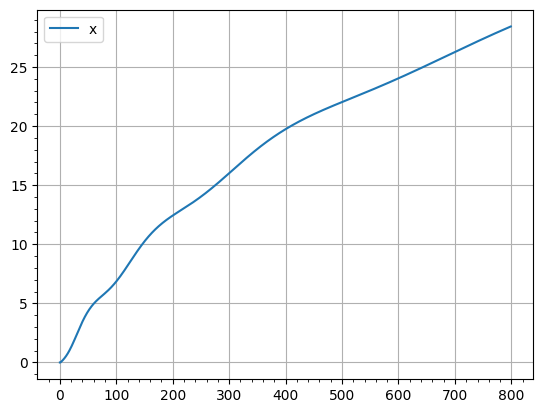

In [12]:
#plotting positions
plt.figure('Leg positions')
plt.plot(leg_positions_x, label='x')
#plt.plot(leg_positions_y, label='y')
#plt.plot(leg_position_z, label='z')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.xlim(0,1000)
#plt.ylim(-0.1,0.1)
plt.show()

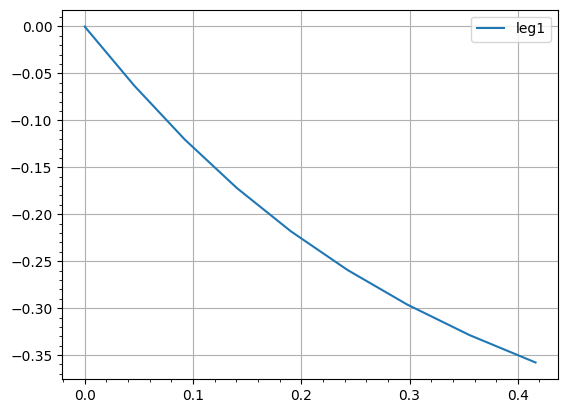

In [13]:
plt.figure('xy motion')
plt.plot(leg_positions_x[0:10], leg_positions_y[0:10], label = 'leg1')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

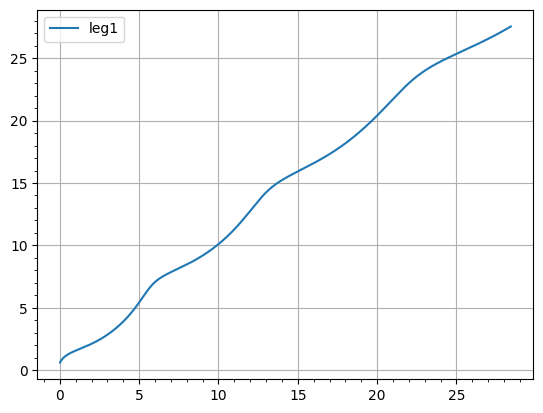

In [14]:
plt.figure('xz motion')
plt.plot(leg_positions_x, leg_position_z, label = 'leg1')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

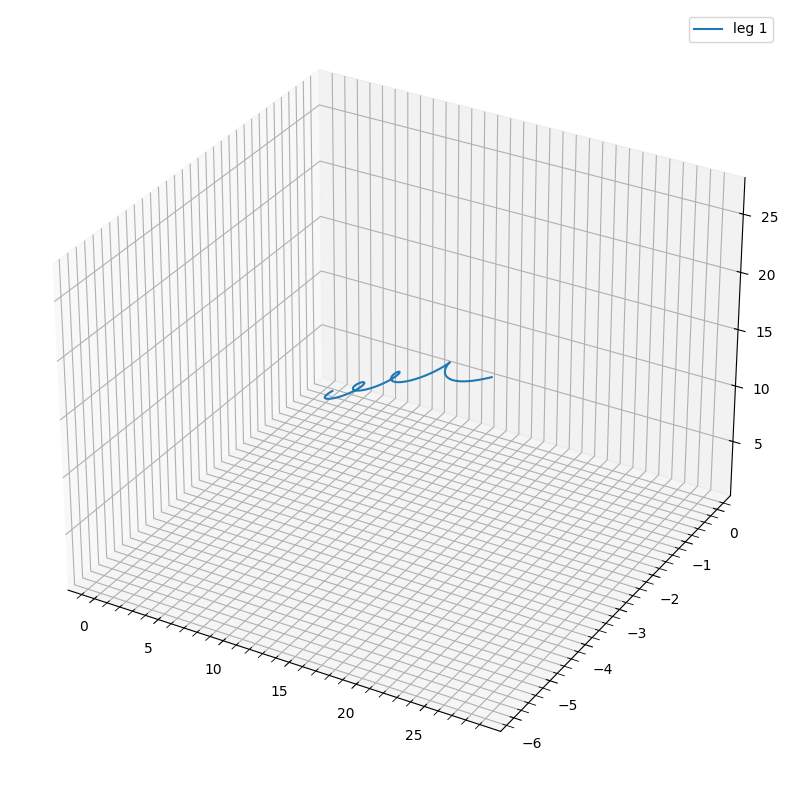

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure('3D motion', figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(leg_positions_x, leg_positions_y, leg_position_z, label = 'leg 1')
plt.legend()
plt.minorticks_on()
plt.show()